In [3]:
from tqdm import tqdm
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download("vader_lexicon")
from nltk.sentiment.vader import SentimentIntensityAnalyzer
vds = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Akhilesh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('../dataset/glove.twitter.27B.200d.txt', encoding="utf8")

for line in tqdm(glove_file):
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

1193514it [00:50, 23801.11it/s]


In [5]:
df = pd.read_csv("data/cleaned_data/df_tweets_cleaned.csv")

In [6]:
obesity = df[df["topic"] == "Obesity"]
sugar_tax = df[df["topic"] == "Sugar tax"]
soda_tax = df[df["topic"] == "Soda tax"]
beverage_tax = df[df["topic"] == "Sweetened beverage tax"]

In [7]:
final_sent_df = pd.concat([sugar_tax, soda_tax, beverage_tax, obesity])

In [8]:
def prepare_cv_data(df, col_name):        
    labels_specific = df[[col_name]].reset_index(drop = True)
    text = df[[col_name]].reset_index(drop = True)
    countVectorizer = CountVectorizer(max_features=5000, strip_accents="ascii") 
    countVector = countVectorizer.fit_transform(df[col_name])
    count_vect_df = pd.DataFrame(countVector.toarray(), columns=countVectorizer.get_feature_names())
    count_vect_df.head()
    return count_vect_df

In [9]:
def get_scores(text):
    sent_dict = vds.polarity_scores(text)
    compound = sent_dict["compound"]
    if compound > 0.05:
        return "Pos"
    elif compound <= -0.05:
        return "Neg"
    else:
        return "Neu"
    return sentiment


In [10]:
from tqdm import tqdm
tqdm.pandas()

In [75]:
obesity["sentiment"] = obesity["tweets_cleaned"].progress_apply(lambda x: get_scores(x))
sugar_tax["sentiment"] = sugar_tax["tweets_cleaned"].progress_apply(lambda x: get_scores(x))
soda_tax["sentiment"] = soda_tax["tweets_cleaned"].progress_apply(lambda x: get_scores(x))
beverage_tax["sentiment"] = beverage_tax["tweets_cleaned"].progress_apply(lambda x: get_scores(x))

100%|██████████████████████████████████████████████████████████████████████████████| 788/788 [00:00<00:00, 2693.02it/s]
C:\Users\Akhilesh\AppData\Local\Temp\ipykernel_32408\3242613569.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████████████████████████████████████████████████████████████████████████| 538/538 [00:00<00:00, 3872.23it/s]
C:\Users\Akhilesh\AppData\Local\Temp\ipykernel_32408\3242613569.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|███████████████████████████████████

In [76]:
final_sent_df = pd.concat([obesity, sugar_tax, soda_tax, beverage_tax], axis=0)

In [13]:
obesity_count_vect_df = prepare_cv_data(obesity, "tweets_cleaned")
labels_obesity = obesity[["sentiment"]]

sugar_tax_count_vect_df = prepare_cv_data(sugar_tax, "tweets_cleaned")
labels_sugar_tax = sugar_tax[["sentiment"]]

soda_tax_count_vect_df = prepare_cv_data(soda_tax, "tweets_cleaned")
labels_soda_tax = soda_tax[["sentiment"]]

beverage_tax_count_vect_df = prepare_cv_data(beverage_tax, "tweets_cleaned")
labels_beverage_tax = beverage_tax[["sentiment"]]

C:\Users\Akhilesh\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Akhilesh\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Akhilesh\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Akhilesh\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprec

In [41]:
from keras.preprocessing.text import one_hot
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers import Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.backend import clear_session
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [63]:


def prepare_data(input_df, method = "logistic_regression"):
    if method == "logistic_regression":
        count_vect_df = prepare_cv_data(input_df, "tweets_cleaned")
        X = count_vect_df.values
        y = []
        for i in input_df["sentiment"]:
            if i == "Pos":
                y.append(0)
            elif i == "Neg":
                y.append(1)
            else:
                y.append(2)
        y = np.array(y)        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
        input_dim = X_train.shape[1]  # Number of features
        return X_train, X_test, y_train, y_test, input_dim

    elif method == "neural_net":
        ohe = OneHotEncoder()
        count_vect_df = prepare_cv_data(input_df, "tweets_cleaned")
        X = count_vect_df.values
        y = input_df[["sentiment"]]
        print(y.columns)
        y_onehot = ohe.fit_transform(y).toarray()         
        X_train,X_test,y_train,y_test = train_test_split(X,y_onehot,test_size = 0.1)
        input_dim = X_train.shape[1]
        return X_train, X_test, y_train, y_test, input_dim
    
    elif method == "lstm":
        ohe = OneHotEncoder()
        X = input_df["tweets_cleaned"]
        y = input_df[["sentiment"]]        
        y_onehot = ohe.fit_transform(y).toarray()         
        X_train,X_test,y_train,y_test = train_test_split(X,y_onehot,test_size = 0.1)
        tokenizer = Tokenizer(num_words=5000)
        tokenizer.fit_on_texts(X_train)

        X_train = tokenizer.texts_to_sequences(X_train)
        X_test = tokenizer.texts_to_sequences(X_test)
        # Adding 1 because of reserved 0 index
        vocab_size = len(tokenizer.word_index) + 1

        maxlen = 200

        X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
        X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
        embedding_matrix = zeros((vocab_size, 200))
        for word, index in tokenizer.word_index.items():
            embedding_vector = embeddings_dictionary.get(word)
            if embedding_vector is not None:
                embedding_matrix[index] = embedding_vector
        
        input_dim = X_train.shape[1]
        return X_train, X_test, y_train, y_test, embedding_matrix, input_dim

In [16]:
def build_lr_model(X_train, X_test, y_train, y_test, input_dim):
    LR_classifier = LogisticRegression()
    LR_classifier.fit(X_train, y_train)
    score = LR_classifier.score(X_test, y_test)

    print("Accuracy:", score)
    return LR_classifier

In [17]:
def build_nn(X_train, X_test, y_train, y_test, input_dim):
    clear_session()
    model = Sequential()
    model.add(Dense(100, input_dim=input_dim, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(12, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam',
                 metrics=['accuracy'])
    model.summary()



    history = model.fit(X_train, y_train,
                         epochs=10,
                         verbose=1,
                         validation_data=(X_test, y_test),
                         batch_size=10)
    return model, history

In [83]:
def build_lstm(X_train, X_test, y_train, y_test, embedding_matrix, input_dim):
    clear_session()
    maxlen = 200
    model = Sequential()
    model.add(Embedding(input_dim=5000, 
                               output_dim=200, 
                               input_length=maxlen))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    #model.summary()

    #model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

    print(model.summary())

    history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.2)
    score = model.evaluate(X_test, y_test, verbose=1)
    return model, history

In [19]:
def plot_acc_loss(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])

    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

In [20]:
def get_metrics(model, input_df, X_test, y_test, method = "logistic_regression"):
    if method == "logistic_regression":
        prediction_linear = model.predict(X_test)
        
    elif method == "neural_net":
        y_pred = model.predict(X_test)
        #Converting predictions to label
        pred = list()
        for i in range(len(y_pred)):
            pred.append(np.argmax(y_pred[i]))
        #Converting one hot encoded test label to label
        test = list()
        for i in range(len(y_test)):
            test.append(np.argmax(y_test[i]))
        a = accuracy_score(pred,test)
        print('Accuracy is:', a*100)
        y_test = test
        prediction_linear = pred
        
    labels_ =  input_df[["sentiment"]]
    col_name = "sentiment"

    cnf_matrix4 = confusion_matrix(y_test, prediction_linear)
    labels = list(labels_[col_name].value_counts().keys())
    fig = px.imshow(cnf_matrix4, 
                    labels=dict(x="Actuals", y="Predicted", color="Items Classified"),
                    x=labels,
                    y=labels,text_auto=True)
    fig.show()
    classification_report_nb = classification_report(y_test, prediction_linear, target_names=labels, digits=4, output_dict=True)
    print(classification_report_nb)
    df = pd.DataFrame(classification_report_nb)
    df.iloc[:3, :3].T.plot(kind='bar')
    plt.show()
    fig2 = px.imshow(np.round(df.iloc[:3, :3].T,2),text_auto=True)
    fig2.show()

### Logistic Regression

C:\Users\Akhilesh\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



Accuracy: 0.8037974683544303


{'Neg': {'precision': 0.8431372549019608, 'recall': 0.7543859649122807, 'f1-score': 0.7962962962962964, 'support': 57}, 'Pos': {'precision': 0.9137931034482759, 'recall': 0.828125, 'f1-score': 0.8688524590163935, 'support': 64}, 'Neu': {'precision': 0.6326530612244898, 'recall': 0.8378378378378378, 'f1-score': 0.7209302325581396, 'support': 37}, 'accuracy': 0.8037974683544303, 'macro avg': {'precision': 0.7965278065249088, 'recall': 0.8067829342500396, 'f1-score': 0.7953596626236098, 'support': 158}, 'weighted avg': {'precision': 0.8224667431354907, 'recall': 0.8037974683544303, 'f1-score': 0.8080371194341092, 'support': 158}}


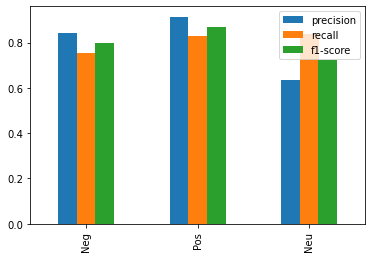

In [42]:
X_train, X_test, y_train, y_test, input_dim = prepare_data(obesity, method="logistic_regression")

model = build_lr_model(X_train, X_test, y_train, y_test, input_dim)

get_metrics(model, obesity, X_test, y_test)


### Neural Nets

C:\Users\Akhilesh\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



Index(['sentiment'], dtype='object')
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               260400    
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 12)                1212      
                                                                 
 dropout_1 (Dropout)         (None, 12)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 39        
                                                                 
Total params: 261,651
Trainable params: 261,651
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
71

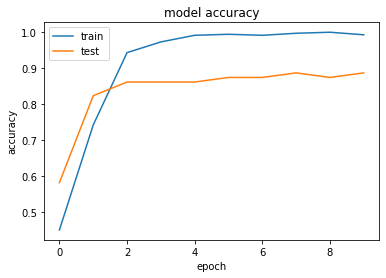

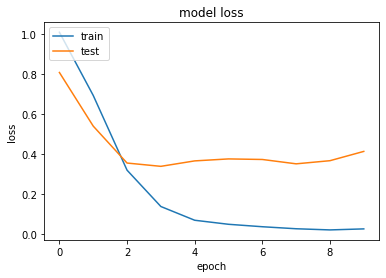

3/3 [==============================] - 0s 5ms/step
Accuracy is: 88.60759493670885


{'Neg': {'precision': 0.8333333333333334, 'recall': 0.9722222222222222, 'f1-score': 0.8974358974358975, 'support': 36}, 'Pos': {'precision': 0.9333333333333333, 'recall': 0.8235294117647058, 'f1-score': 0.8749999999999999, 'support': 17}, 'Neu': {'precision': 0.9545454545454546, 'recall': 0.8076923076923077, 'f1-score': 0.875, 'support': 26}, 'accuracy': 0.8860759493670886, 'macro avg': {'precision': 0.907070707070707, 'recall': 0.8678146472264118, 'f1-score': 0.8824786324786325, 'support': 79}, 'weighted avg': {'precision': 0.8947449175297277, 'recall': 0.8860759493670886, 'f1-score': 0.8852239532619279, 'support': 79}}


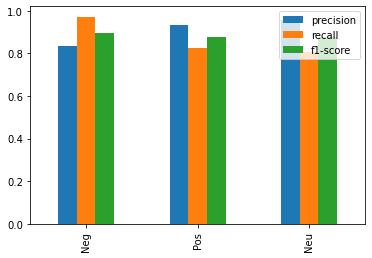

In [43]:
X_train, X_test, y_train, y_test, input_dim = prepare_data(obesity, method = "neural_net")

model, history = build_nn(X_train, X_test, y_train, y_test, input_dim)

plot_acc_loss(history)

get_metrics(model, obesity, X_test, y_test, method = "neural_net")

### LSTM + Embeddings

In [77]:
X_train, X_test, y_train, y_test, embedding_matrix, input_dim = prepare_data(final_sent_df, method = "lstm")

In [84]:
model, history = build_lstm(X_train, X_test, y_train, y_test, embedding_matrix, X_train.shape[0])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 200)          1000000   
                                                                 
 global_max_pooling1d (Globa  (None, 200)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                2010      
                                                                 
 dense_1 (Dense)             (None, 3)                 33        
                                                                 
Total params: 1,002,043
Trainable params: 1,002,043
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
9/9 [==============================] - 2s 82ms/step - loss: 1.0835 - accuracy: 0.3790 - val_loss

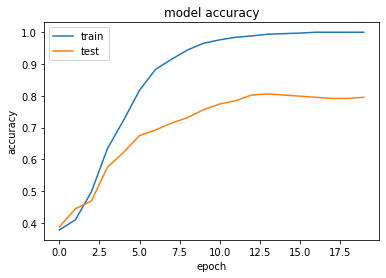

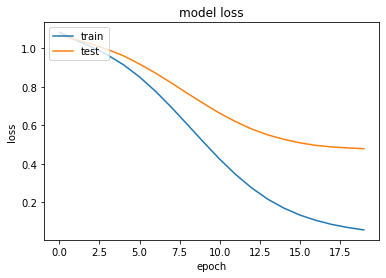

In [85]:
plot_acc_loss(history)

5/5 [==============================] - 0s 5ms/step
Accuracy is: 58.22784810126582


{'Neg': {'precision': 1.0, 'recall': 0.3050847457627119, 'f1-score': 0.4675324675324675, 'support': 59}, 'Pos': {'precision': 0.8333333333333334, 'recall': 0.375, 'f1-score': 0.5172413793103448, 'support': 40}, 'Neu': {'precision': 0.48360655737704916, 'recall': 1.0, 'f1-score': 0.6519337016574586, 'support': 59}, 'accuracy': 0.5822784810126582, 'macro avg': {'precision': 0.7723132969034608, 'recall': 0.5600282485875706, 'f1-score': 0.5455691828334236, 'support': 158}, 'weighted avg': {'precision': 0.7649754444213877, 'recall': 0.5822784810126582, 'f1-score': 0.5489756908520218, 'support': 158}}


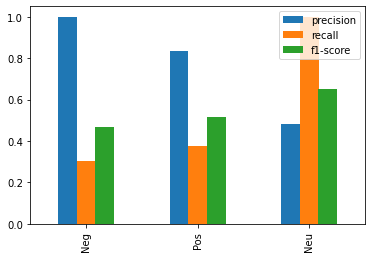

In [82]:
get_metrics(model, obesity, X_test, y_test, method = "neural_net")

### Using Embeddings